STC, Cube, Time Series, and VODML Demo
==========================

O. Laurino - October, 27th 2017

Table of Contents
---------------------

  * [Introduction](#introduction)
  * [VODML Parser](#parser)
  * [VODML Python framework](#framework)
  * [STC](#models)
    * [IVOA basic model](#ivoa)
    * [Coordinates model](#coords)
    * [Measurements model](#meas)
    * [A simple Astropy STC client](#astropy)
  * [Time Series](#timeseries)
    * [Dataset model](#dataset)
    * [Cube model](#cube)
    * [An advanced plotting client](#plotting)
  * [Invariance of VODML serializations](#invariance)  
  * [Tests](#tests)
  

<a id="introduction"></a>
Introduction
---------------

This notebook provides examples on how to parse and use information stored in VOTable according to a number of data models, the VODML Proposed Recommendation, and the Mapping VODML in VOTable Working Draft (as of October 2017).

In particular, this notebook provides:
  * serializations of **STC** instances
  * serializations of **time series** instances according to the **Cube** model
  * a simple serialization of the **Dataset** model that annotates the time series
  * a simple **VODML** Python framework to represent VODML models in Python
  * a **VODML Mapping parser** to parse instances of data models from VOTable serializations
  * implementations of more or less advanced clients using **Astropy** and **Matplotlib**
  
The VODML Python framework allows VODML models to be represented as Python data structures (classes and their attributes) in a strict 1:1 (albeit simplified in this notebook) fashion. The parser then deserializes VOTable/VODML instances into such Python structures. Generic clients are then implemented at the end of the notebook with widely used Python packages like Astropy and Matplotlib to show how the deserialized instances can be used in useful clients that implement specific data models.

We also show how different data models can be used to annotate the same VOTable, and how the information from these models can be combined in clients. In this case we show a complex example of a real world time series dataset (courtesy of the German Astronomical Virtual Observatory) annotated according to both the Cube and Dataset data models, which are currently disjoint.

Note that the parser is non-validating, i.e. it won't generally catch semantic errors in the serializations. For example, if a role is filled by an instance of a type that cannot represent that role, the parser will happily produce a perfectly fine Python object that represents the bogus relationship.

Before you start
--------------------

We decided to make this notebook self-contained, which makes it rather verbose. However, it shows simple but realistic implementations of all the components required to make use of the ecosystem of standards currently under development (STC, Cube, Dataset, VODML, VODML Mapping). Different readers may be interested in different sections of this document. The Table of Contents above allows readers to skip sections they are not interested in.

<a id="parser"></a>
The Parser
----------
The cell below implements a parser for the [*Mapping VODML instances VOTable*](http://volute.g-vo.org/svn/trunk/projects/dm/vo-dml-mapping/doc/) specification. It implements much of the specification, enough for parsing the examples. However, it's not complete above all it lacks proper error handling. It's also not optimized.

To make the notebook complete and self-contained, and since writing a parser for the *VODML Mapping* specification from scratch is rather straighforward, the parser implementation is included here in full.

For simplicity, the parser implemented below only works on Python 3.6.

In [1]:
ns = {'def': 'http://www.ivoa.net/xml/VOTable/v1.4'}

class AbstractParser:
    """
    Concrete parser must extend this class and provide a method parse(self, vodml_parser, xml_element)
    """
    def __init__(self, descriptor):
        self.vodml_id = descriptor.vodml_id

        
class AttributeListParser(AbstractParser):
    """
    Parser for attribute lists, i.e. attributes of any multiplicity greater than 1.
    """
    
    def parse(self, vodml_parser, xml_element):
        return self._parse_attributes(vodml_parser, xml_element)
    
    def _parse_attributes(self, vodml_parser, xml_element):
        role_id = self.vodml_id
        attribute_elements = xml_element.xpath(f"def:ATTRIBUTE[@dmrole='{role_id}']", namespaces=ns)
        
        if not len(attribute_elements):
            return (None,)
        
        attributes = []
        
        for attribute_element in attribute_elements:
            instance_elements = attribute_element.xpath("child::def:INSTANCE", namespaces=ns)
            literal_elements = attribute_element.xpath("child::def:LITERAL", namespaces=ns)
            column_elements = attribute_element.xpath("child::def:COLUMN", namespaces=ns)
            
            if len(instance_elements):
                attributes.append(vodml_parser.parse_instance(instance_elements[0]))

            elif len(literal_elements):
                attributes.append(self._parse_literal(vodml_parser, literal_elements[0]))  
            
            elif len(column_elements):
                attributes.append(self._parse_column(vodml_parser, column_elements[0]))
                
        return tuple(attributes)

    def _parse_literal(self, vodml_parser, xml_element):
        value = xml_element.xpath("@value")[0]
        value_type = xml_element.xpath("@dmtype")[0]
        units = xml_element.xpath("@unit")
        unit = units[0] if len(units) else None
        return vodml_parser.get_by_id(value_type)(value, unit)
    
    def _parse_column(self, vodml_parser, xml_element):
        import astropy.units as u
        
        table = self._parse_table(xml_element)
        
        column_ref = xml_element.xpath("@ref")[0]
        value_type = xml_element.xpath("@dmtype")[0]
        find_column_xpath = f"//def:FIELD[@ID='{column_ref}']"
        find_index_xpath = f"count({find_column_xpath}/preceding-sibling::def:FIELD)"
        column_element = xml_element.xpath(find_column_xpath, namespaces=ns)[0]
        column_index = int(xml_element.xpath(find_index_xpath, namespaces=ns))
        column = table[:, column_index]
        
        units = column_element.xpath("@unit")
        unit = units[0] if len(units) else None
        
        quantity = True  # whether this is an astropy quantity.
        if unit is not None:
            column = column*u.Unit(unit, parse_strict='warn')
        else:
            try:  # any (numerical) column astropy can handle
                column = u.Quantity(column)
            except:
                quantity = False
        
        if quantity:
            name = column_element.xpath("@name")[0]
            column.name = name
        
        return column
    
    def _parse_table(self, xml_element):
        from lxml import etree
        from pandas import read_html
        table_html = etree.tostring(xml_element.xpath("//def:TABLEDATA", namespaces=ns)[0])
        return read_html(f"<table>{table_html}</table>")[0].as_matrix()
    
        
    
class AttributeParser(AttributeListParser):
    """
    Parser for attributes of multiplicity = 1. This parser is basically an AttributeListParser that returns
    a single instance rather than a tuple.
    """
        
    def parse(self, vodml_parser, xml_element):
        return self._parse_attribute(vodml_parser, xml_element)
        
    def _parse_attribute(self, vodml_parser, xml_element):
        attributes = self._parse_attributes(vodml_parser, xml_element)
        if len(attributes):
            return attributes[0]
        return None
    

class CompositionParser(AbstractParser):
    """
    Parser for composition relationships.
    """
        
    def parse(self, vodml_parser, xml_element):
        role_id = self.vodml_id
        elements = xml_element.xpath(f"./def:COMPOSITION[@dmrole='{role_id}']/child::def:INSTANCE", namespaces=ns)
        return [vodml_parser.parse_instance(element) for element in elements]

    
class ReferenceParser:
    """
    Parser for references.
    """
    def __init__(self, descriptor):
        self.vodml_id = descriptor.vodml_id
        
    def parse(self, vodml_parser, xml_element):
        role_id = self.vodml_id
        reference_elements = xml_element.xpath(f"./def:REFERENCE[@dmrole='{role_id}']", namespaces=ns)
        if not len(reference_elements):
            return None
        
        reference_element = reference_elements[0]
        
        id_ref = reference_element.xpath("./def:IDREF", namespaces=ns)[0].text
        
        referred_element = reference_element.xpath(f"//def:INSTANCE[@ID='{id_ref}']", namespaces=ns)[0]
        
        # FIXME: way too simplistic: referenced instances should have their own lifecycle
        # and be just referenced by the referrers, rather than attached to them.
        # The problem here is that an instance referenced twice would be instantiated
        # twice, and there would be no link between the two. Really, what should happen is that
        # a weak value dictionary should be created so that referenced instances have a life
        # of their own and changes to an instance should be reflected across the process.
        # As per usual garbage collection processing, referenced instances should be
        # garbage collected when no referring objects are to be found, hence the
        # weak value dictionary.
        return vodml_parser.parse_instance(referred_element)

        
class TypeRegistry:
    """
    This class provides a registry to resolve types from their vodml_ids. In this simple
    implementation the types are found among all the classes in the global namespace
    (see `find_globals` method).
    """
    def __init__(self):
        self._type_map = {}
        self.find_globals()
        
    def get_by_id(self, vodml_id):
        element_class = self._type_map.get(vodml_id, None)
        if element_class is None:
            raise ValueError(f"Cannot find element with type id: {vodml_id}")
        return element_class
    
    def find_globals(self):
        import inspect
        for _, obj in globals().copy().items():
            if hasattr(obj, 'vodml_id') and inspect.isclass(obj):
                self._type_map[obj.vodml_id] = obj
    
    
class InstanceFactory:
    """
    A factory that makes instances of a class based on an `INSTANCE` xml Element. 
    """
    @staticmethod
    def make(instance_class, xml_element, parser):
        """
        instance_class is the class to be instantiated
        xml_element is the xml Element serializing the instance
        parser is the VodmlParser instance passed through to provide context.
        """
        import inspect
        
        def is_field(x):
            return inspect.isdatadescriptor(x) and isinstance(x, VodmlDescriptor)
        
        fields = inspect.getmembers(instance_class, is_field)
        
        instance = instance_class()
        
        for field_tuple in fields:
            field_name, field_object = field_tuple
            setattr(instance, field_name, field_object.parse(parser, xml_element))
            
        return instance


class VodmlParser:
    """
    Root Parser.
    """
    def __init__(self, xml_document):
        self.root = self._find_root(xml_document)
        self.registry = TypeRegistry()
        self.factory = InstanceFactory
        
    def find_instances(self, element_class):
        """
        Find all instances of the `element_class` class in a votable.
        """
        type_id = element_class.vodml_id
        elements = self.root.xpath(f"//def:INSTANCE[@dmtype='{type_id}']", namespaces=ns)
        return [self.parse_instance(element) for element in elements]
    
    def parse_instance(self, xml_element):
        """
        Parse an `INSTANCE` represented by the `xml_element`
        """
        element_class = self._resolve_type(xml_element)
        return self.factory.make(element_class, xml_element, self)
    
    def get_by_id(self, vodml_id):
        "Resolve a vodml_id to the corresponding class"
        return self.registry.get_by_id(vodml_id)
        
    def _find_root(self, xml_document):
        from lxml import etree
        parser = etree.XMLParser(ns_clean=True)
        tree = etree.parse(xml_document, parser)
        return tree.getroot()
    
    def _resolve_type(self, xml_element):
        element_type = xml_element.xpath("@dmtype", namespaces=ns)[0]
        element_class = self.registry.get_by_id(element_type)
        return element_class

<a id="framework"></a>
A simple VODML Python Framework
---------------------------------

The cell below implements a simple Python framework for representing VODML models in Python in a convenient declarative way. If you ever worked with a framework like Django or SQLAlchemy you'll find the model representations quite familiar. Again, not all of the VODML meta-model is implemented, multiplicities are treated in a rather crude way, and no validation is performed. That being said, few lines of Python provide a perfectly usable framework.

In [2]:
class VodmlDescriptor:
    """
    An abstract class implementing the Descriptor Protocol as a basis for describing VODML models
    in Python. Other than the regular descriptor methods, the class also provides a parse method
    that provides an API for parsing data fields of model classes. A parser can find all descriptors
    in a class and call the `parse` method to instantiate its fields.
    
    Note that extending classes **must** define a `self._parser` field as a delegate of the `parse` method.
    """
    def __init__(self, vodml_id):
        self.vodml_id = vodml_id
        self.default = None
    
    def __get__(self, instance, owner):
        if instance is None:
            return self
        return instance.__dict__.get(self.name, self.default)
    
    def __set__(self, instance, value):
        instance.__dict__[self.name] = value
        
    def __set_name__(self, owner, name):
        self.name = name
        
    def parse(self, vodml_parser, xml_element):
        return self._parser.parse(vodml_parser, xml_element)
        

class Composition(VodmlDescriptor):
    def __init__(self, vodml_id):
        VodmlDescriptor.__init__(self, vodml_id)
        self._parser = CompositionParser(self)


class AttributeList(VodmlDescriptor):
    def __init__(self, vodml_id):
        VodmlDescriptor.__init__(self, vodml_id)
        self._parser = AttributeListParser(self)
        

class Attribute(AttributeList):
    def __init__(self, vodml_id):
        VodmlDescriptor.__init__(self, vodml_id)
        self._parser = AttributeParser(self)
        
        
class Reference(VodmlDescriptor):
    def __init__(self, vodml_id):
        VodmlDescriptor.__init__(self, vodml_id)
        self._parser = ReferenceParser(self)

<a id="models"></a>
The Models
----------
The following cells define actual models using the framework created above. These representations are easily generated automatically, but for the benefit of clarity they are described explicitly here.

<a id="ivoa"></a>
IVOA basic model
----------------------
First we define implementations for some basic quantities from the [IVOA basic model](http://volute.g-vo.org/svn/trunk/projects/dm/vo-dml/models/ivoa/vo-dml/IVOA-v1.0.html). For simplicity, we don't differentiate between primitives and quantities, and we treat both as quantities. This is not necessarily advisable in production code, but it works for the purposes of this notebook.

In [3]:
class RealQuantity:
    """
    Represents ivoa:RealQuantity
    """
    vodml_id = "ivoa:RealQuantity"
    
    def __init__(self, value, unit):
        self.value = float(value)
        self.unit = unit
        
        
class StringQuantity:
    """
    Represents all ivoa:* quantities that can be represented with a string in Python.
    In this simple implementation that does not provide validation, enumerations are
    also treated as simple strings.
    """
    vodml_id = "ivoa:string"
    
    def __init__(self, value, unit):
        self.value = str(value)
        self.unit = unit

        
class BooleanQuantity:
    """
    Represents ivoa:boolean
    """
    vodml_id = "ivoa:boolean"
    
    def __init__(self, value, unit):
        self.value = value.lower() == 'true'
        self.unit = unit
        
        
class Uri(StringQuantity):
    vodml_id = "ivoa:anyURI"

<a id="coords"></a>
Coordinates Model
---------------------

The STC model was split in three submodules. At the base we have the [`coords`](/ivoa-dm-examples/assets/examples/stc2/shortcuts/models/STC_coords-v2.0.html) model, which defines types that have to do with frames and coordinates. For simplicity, and since there are no ambiguities in the type names, we omit the package structure of the model and we define all the classes in the same namespace.

Note that not all of `coords` is defined here, only the classes that correspond to types that we are going to use in the demo.

Again, all these classes could easily be automatically generated from the VODML model descriptions, but are included here in explicitly for clarity. Also, as we are not performing any validation, many types are simply associated to strings.

In [4]:
class RefLocation:
    vodml_id = "coords:domain.space.RefLocation"
    

class StdRefLocation:
    vodml_id = "coords:domain.space.StdRefLocation"
    position = Attribute("coords:domain.space.StdRefLocation.position")
    

class Coordinate:
    vodml_id = "coords:Coordinate"
    frame = Reference('coords:Coordinate.frame')

    
class SpaceCoord(Coordinate):
    vodml_id = "coords:domain.space.SpaceCoord"

    
class EquatorialCoord(SpaceCoord):
    vodml_id = "coords:domain.space.EquatorialCoord"
    ra = Attribute("coords:domain.space.EquatorialCoord.ra")
    dec = Attribute("coords:domain.space.EquatorialCoord.dec")

    
class CoordFrame:
    vodml_id = "coords:CoordFrame"
    
    
class TimeFrame(CoordFrame):
    vodml_id = "coords:domain.time.TimeFrame"
    ref_position = Attribute("coords:domain.time.TimeFrame.refPosition")
    timescale = Attribute("coords:domain.time.TimeFrame.timescale")
    
    
class SpaceFrame(CoordFrame):
    vodml_id = "coords:domain.space.SpaceFrame"
    ref_position = Attribute("coords:domain.space.SpaceFrame.refPosition")
    space_ref_frame = Attribute("coords:domain.space.SpaceFrame.spaceRefFrame")
    equinox = Attribute("coords:domain.space.SpaceFrame.equinox")
    
    
class TimeScale(StringQuantity):
    """
    For simplicity, assume this is just a string, which is fine for this notebook.
    """
    vodml_id = "coords:domain.time.TimeScale"
    
    
class Coordinate:
    vodml_id = "coords:Coordinate"
    frame = Reference('coords:Coordinate.frame')
    

class TimeStamp(Coordinate):
    vodml_id = "coords:domain.time.TimeStamp"


class TimeInstant(TimeStamp):
    vodml_id = "coods:domain.time.TimeInstant"
    
    
class ISOTime(TimeInstant):
    vodml_id = "coords:domain.time.ISOTime"
    date = Attribute("coords:domain.time.ISOTime.date")
    
    
class JD(TimeInstant):
    vodml_id = 'coords:domain.time.JD'
    date = Attribute('coords:domain.time.JD.date')
    

class CoordValue(Coordinate):
    vodml_id = "coords:CoordValue"
    axis = Reference("coords:CoordValue.axis")
    
    
class PhysicalCoordValue(CoordValue):
    vodml_id = "coords:PhysicalCoordValue"
    cval = Attribute("coords:PhysicalCoordValue.cval")
    
class Epoch(StringQuantity):
    """
    For simplicity, assume this is just a string, which is fine for this notebook.
    """
    vodml_id = "coords:domain.space.Epoch"
    
    
class StdRefPosition(StringQuantity):
    """
    For simplicity, assume this is just a string, which is fine for this notebook.
    """
    vodml_id = "coords:domain.space.StdRefPosition"
    
    
class StdRefFrame(StringQuantity):
    """
    For simplicity, assume this is just a string, which is fine for this notebook.
    """
    vodml_id = "coords:domain.space.StdRefFrame"   

<a id="meas"></a>
Measurements Model
----------------------

The [`meas`](/ivoa-dm-examples/assets/examples/stc2/shortcuts/models/STC_meas-v2.0.html) model defines types for measurements, including convenient shortcuts for measurement that are often used in Astronomy, like `SkyPosition`, which represents a celestial coordinate. It also introduces error structures. Again, we are not defining classes for all of the types in the model, but only those types we need for the demo.

In [5]:
class CoordMeasure:
    vodml_id = "meas:CoordMeasure"
    coord = Attribute("meas:CoordMeasure.coord")
    error = Composition("meas:CoordMeasure.error")
    
    
class GenericCoordMeasure(CoordMeasure):
    vodml_id = "meas:GenericCoordMeasure"
    
    
class TimeMeasure(CoordMeasure):
    vodml_id = "meas:TimeMeasure"
    
    
class StdTimeMeasure(TimeMeasure):
    vodml_id = "meas:StdTimeMeasure"
        
        
class StdPosition(CoordMeasure):
    vodml_id = "meas:StdPosition"
        

class Error:
    vodml_id = "meas:Error"
    
    
class Error1D(Error):
    vodml_id = "meas:Error1D"
    stat_error = Attribute("meas:Error1D.statError")
    sys_error = Attribute("meas:Error1D.sysError")
    ran_error = Attribute("meas:Error1D.ranError")

    
class Error2D(Error):
    vodml_id = "meas:Error2D"
    stat_error = Attribute("meas:Error2D.statError")
    sys_error = Attribute("meas:Error2D.sysError")
    ran_error = Attribute("meas:Error2D.ranError")

        
class Uncertainty:
    vodml_id = "meas:Uncertainty"
    
    
class Uncertainty1D(Uncertainty):
    vodml_id = "meas:Uncertainty1D"
    
    
class Symmetrical1D(Uncertainty1D):
    vodml_id = "meas:Symmetrical1D"
    radius = Attribute("meas:Symmetrical1D.radius")
        
        
class Uncertainty2D(Uncertainty):
    vodml_id = "meas:Uncertainty2D"

        
class Ellipse(Uncertainty2D):
    vodml_id = "meas:Ellipse"
    semi_axis = AttributeList("meas:Ellipse.semiAxis")
    pos_angle = Attribute("meas:Ellipse.posAngle")
    
    
class Symmetrical2D(Uncertainty2D):
    vodml_id = "meas:Symmetrical2D"
    radius = Attribute("meas:Symmetrical2D.radius")

<a id="usage"></a>
Parsing instances
-----------------

Having defined a parser, a framework for describing VODML models in Python, and some actual models, we can try and parse some actual serializations. Below is a string representing a VOTable with a simple standalone `StdPosition` instance and the space frame it refers to.

In [6]:
from io import BytesIO

xml = BytesIO(b"""<?xml version="1.0" encoding="utf-8"?><VOTABLE xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
  <VODML>
    <MODEL>
      <NAME>coords</NAME>
      <URL>file:../models/STC_coords-v2.0.vo-dml.xml</URL>
    </MODEL>
    <MODEL>
      <NAME>meas</NAME>
      <URL>file:../models/STC_meas-v2.0.vo-dml.xml</URL>
    </MODEL>
    <MODEL>
      <NAME>ivoa</NAME>
      <URL>https://volute.g-vo.org/svn/trunk/projects/dm/vo-dml/models//ivoa/vo-dml/IVOA-v1.0.vo-dml.xml</URL>
    </MODEL>
    <GLOBALS>
      <INSTANCE dmtype="coords:domain.space.SpaceFrame" ID="_SPACE_FRAME">
        <ATTRIBUTE dmrole="coords:domain.space.SpaceFrame.spaceRefFrame">
          <LITERAL value="FK5" dmtype="coords:domain.space.StdRefFrame"/>
        </ATTRIBUTE>
        <ATTRIBUTE dmrole="coords:domain.space.SpaceFrame.equinox">
          <LITERAL value="J1975" dmtype="coords:domain.space.Epoch"/>
        </ATTRIBUTE>
        <ATTRIBUTE dmrole="coords:domain.space.SpaceFrame.refPosition">
          <INSTANCE dmtype="coords:domain.space.StdRefLocation">
            <ATTRIBUTE dmrole="coords:domain.space.StdRefLocation.position">
              <LITERAL value="TOPOCENTER" dmtype="coords:domain.space.StdRefPosition"/>
            </ATTRIBUTE>
          </INSTANCE>
        </ATTRIBUTE>
      </INSTANCE>
      <INSTANCE dmtype="meas:StdPosition">
        <ATTRIBUTE dmrole="meas:CoordMeasure.coord">
          <INSTANCE dmtype="coords:domain.space.EquatorialCoord">
            <ATTRIBUTE dmrole="coords:domain.space.EquatorialCoord.ra">
              <LITERAL value="10.34209135" dmtype="ivoa:RealQuantity" unit="deg"/>
            </ATTRIBUTE>
            <ATTRIBUTE dmrole="coords:domain.space.EquatorialCoord.dec">
              <LITERAL value="41.13232112" dmtype="ivoa:RealQuantity" unit="deg"/>
            </ATTRIBUTE>
            <REFERENCE dmrole="coords:Coordinate.frame">
                <IDREF>_SPACE_FRAME</IDREF>
            </REFERENCE>
          </INSTANCE>
        </ATTRIBUTE>
      </INSTANCE>
    </GLOBALS>
  </VODML>
</VOTABLE>
""")

The cell below does the actual parsing. We use the `find_instances` method to get all of the instances of a certain type, i.e. the `StdPosition` type. In this case only one instance is present, but we'll look at a more complex example below.

In [7]:
parser = VodmlParser(xml)
sky_positions = parser.find_instances(StdPosition)
pos = sky_positions[0]

<a id="astropy"></a>
A minimalistic Astropy STC client
-----------------------------------------

Model classes like the ones introduced above do not implement any logic, they are just representing the types in a VODML model. However, they can be used to build useful clients as shown below.

As [Astropy](http://www.astropy.org/) provides a rich package for astronomical coordinates manipulation, all we need to do something useful of the position we just parsed is to provide an adapter class that transforms the position into an Astropy object.

The cell below does exactly this, by encapsulating an `stc_position` into an `astropy.coordinates.SkyCoord` object.

Such a class (maybe better equipped in terms of error handling) could be part of an STC library that enables using Astropy on VO serializations.

In [8]:
class VoSkyCoord:
    """
    A drop-in replacement for astropy's SkyCoord. The initializer takes a basic SkyPosition
    instance and builds an astropy.coordinates.SkyCoord object that it then uses as a delegate for all calls
    and assignments.
    """
    def __init__(self, stc_position):
        from astropy.coordinates import SkyCoord
        from astropy import units as u
        
        frame = stc_position.coord.frame.space_ref_frame.value.lower()
        equinox = stc_position.coord.frame.equinox.value
        ra = stc_position.coord.ra.value
        ra_unit = stc_position.coord.ra.unit
        dec = stc_position.coord.dec.value
        dec_unit = stc_position.coord.dec.unit

        ra_quantity = ra*u.Unit(ra_unit)
        dec_quantity = dec*u.Unit(dec_unit)
        
        sky_coord = SkyCoord(frame=frame, equinox=equinox, ra=ra_quantity, dec=dec_quantity)
        
        super().__setattr__('sky_coord', sky_coord)
        
    def __getattr__(self, attr):
        return getattr(self.sky_coord, attr)
    
    def __setattr__(self, attr, value):
        setattr(self.sky_coords, attr, value)
        
    def __str__(self):
        return self.sky_coord.__str__()
    
    def __repr__(self):
        return self.sky_coord.__repr__()

So now we can take advantage of Astropy's capabilities to transform the position from one frame to another, or to get the corresponding galactic coordinates.

In [9]:
from numpy.testing import assert_approx_equal
from astropy.coordinates import FK5

astropos = VoSkyCoord(pos)

astropos_fk5_j2000 = astropos.transform_to(FK5(equinox="J2000"))
astropos_icrs = astropos_fk5_j2000.transform_to('icrs')
astropos_galactic = astropos_icrs.galactic

print(f"""
original coordinate:
  RA={pos.coord.ra.value} DEC={pos.coord.dec.value}
  Frame={pos.coord.frame.space_ref_frame.value}
  Equinox={pos.coord.frame.equinox.value}
  
FK5 J2000 (deg):
  RA={astropos_fk5_j2000.fk5.ra.deg} DEC={astropos_fk5_j2000.fk5.dec.deg}
  
FK5 J2000 (centiradian):
  RA={astropos_fk5_j2000.fk5.ra.centiradian} DEC={astropos_fk5_j2000.fk5.dec.centiradian}
  
ICRS (deg):
  RA={astropos_icrs.ra.deg} DEC={astropos_icrs.dec.deg}
  
Galactic (deg):
  l={astropos_galactic.l.deg} b={astropos_galactic.b.deg}
""")


original coordinate:
  RA=10.34209135 DEC=41.13232112
  Frame=FK5
  Equinox=J1975
  
FK5 J2000 (deg):
  RA=10.684591543245 DEC=41.269171456186264
  
FK5 J2000 (centiradian):
  RA=18.648130166036736 DEC=72.0282921480513
  
ICRS (deg):
  RA=10.684580003955459 DEC=41.269169997096114
  
Galactic (deg):
  l=121.17424181434197 b=-21.57288557543883



<a id="timeseries"></a>
Time Series Example
===========

A time series can be seen in two ways. First and foremost, it is a data set, so it can be represented using the Dataset data model. More specifically, it is a special instance of a cube, with time measurements on the dependent axis. As such, a time series can be represented according to the Cube data model.

Note that the two natures can be disjoint, with a different set of annotations for describing the *dataset* and the *timeseries*

<a id="dataset"></a>
The Dataset model
------------------

Let's define Python classes representing the Dataset VODML model.

In [10]:
class DataID:
    vodml_id = "ds:dataset.DataID"
    title = Attribute("ds:dataset.DataID.title")
    

class Dataset:
    vodml_id = "ds:dataset.Dataset"
    data_product_type = Attribute("ds:dataset.Dataset.dataProductType")
    data_id = Composition("ds:dataset.Dataset.dataID")
    curation = Composition("ds:dataset.Dataset.curation")

    
class Curation:
    vodml_id = "ds:dataset.Curation"
    publisher_did = Attribute("ds:dataset.Curation.publisherDID")
    reference = Composition("ds:dataset.Curation.reference")
    

class Publication:
    vodml_id = "ds:dataset.Publication"
    ref_code = Attribute("ds:dataset.Publication.refCode")
    
    
class ObsDataset(Dataset):
    vodml_id = "ds:experiment.ObsDataset"
    target = Attribute("ds:experiment.ObsDataset.target")
    
    
class BaseTarget:
    vodml_id = "ds:experiment.BaseTarget"
    name = Attribute("ds:experiment.BaseTarget.name")
    
    
class Target(BaseTarget):
    vodml_id = "ds:experiment.Target"
    
    
class DataProductType(StringQuantity):
    """
    For simplicity, assume this is just a string, which is fine for this notebook.
    """
    vodml_id = "ds:dataset.DataProductType"

<a id="cube"></a>
The Cube Model
---------------

Now let's define a very limited number of Cube classes. We can do a number of interesting things with just few elements (and the Cube model is itself rather small, taking advantage of other models as its building blocks).

In [11]:
class NdPoint:
    vodml_id = "cube:NDPoint"
    observable = Composition("cube:NDPoint.observable")
    
    
class DataAxis:
    vodml_id = "cube:DataAxis"
    dependent = Attribute("cube:DataAxis.dependent")
    

class MeasurementAxis(DataAxis):
    vodml_id = 'cube:MeasurementAxis'
    measure = Composition('cube:MeasurementAxis.measure')
    

class Observable(MeasurementAxis):
    vodml_id = "cube:Observable"

A Time Series Example Dataset
------------------------------------

The time series votable was too big to be embedded in the notebook. However it is [also available in this site](/ivoa-dm-examples/notebooks/time-series.vot.xml). The data comes from an [actual data set](http://dc.zah.uni-heidelberg.de/getproduct/k2c9vst/data/MOA-2016-BLG-0254_VST_r_SDSS78.t), courtesy of the [German Astrophysical Virtual Observatory (GAVO)](http://www.g-vo.org/).

We parse the VOTable as both a time series and a data set.

In [12]:
time_series_xml = "time-series.vot.xml"

ts_parser = VodmlParser(time_series_xml)

points = ts_parser.find_instances(NdPoint)
dataset = ts_parser.find_instances(ObsDataset)[0]

ts = points[0]

<a id="plotting"></a>
An advanced plotting client
---------------------------------

We can put everything together in a generic plotting client that greatly simplifies the generation of plots. We can complicate the client at will, but in this case we will just produce a client that:

  * takes istances of a time series and the corresponding dataset from VODML/VOTable serializations
  * allows the user to plot an x array, a y array, and the corresponding errors using the names of their corresponding VOTable columns.
  * it can deal with STC positions, times, and generic measurements.
  * to keep things simple, it assumes a simple symmetric error
  
The original file has very small errors, so in order to make the error bars visible the client has a "bug" that multiplies the errors by 10.

The cell below provides an implementation of a simple client implementing the above requirements and rather generic. We are not including any knowledge about the specific file (although we are indeed making some assumptions and we could do better with error handling).

In [13]:
class VoAxis:
    def __init__(self, axis):
        self._axis = axis
        self.error = self._init_error(axis)
            
    def _init_error(self, axis):
        # FIXME this is way too simplistic, even for this notebook
        # it doesn't take into account the different possible error types
        try:
            return axis.measure[0].error[0].stat_error.radius
        except IndexError:
            return None

    @classmethod
    def is_vo_axis_for(cls, axis):
        return isinstance(axis.measure[0], cls.model_class)

        
class TimeAxis(VoAxis):
    model_class = StdTimeMeasure
    
    def __init__(self, axis):
        super().__init__(axis)
        self.value, self.unit, self.name = self._init_value(axis)
        
    def _init_value(self, axis):
        from astropy.time import Time
        from numpy import nan_to_num

        time = axis.measure[0]
        scale = 'tt' if time.coord.frame is None else time.coord.frame.timescale.value.lower()
        t_format = "iso" if isinstance(time.coord.date, ISOTime) else "jd"
        # Astropy doesn't support nan in Time objects yet (should be coming in Astropy 3)
        date = nan_to_num(time.coord.date)
        value = Time(date, scale=scale, format=t_format).value
        unit = time.coord.date.unit
        name = time.coord.date.name
        return value, unit, name
    
    
class StdPositionAxis(VoAxis):
    name = 'position'
    model_class = StdPosition
    
    
class GenericCoordMeasureAxis(VoAxis):
    name = 'generic'
    model_class = GenericCoordMeasure
    
    def __init__(self, axis):
        super().__init__(axis)
        quantity = axis.measure[0].coord.cval
        self.__quantity = quantity
        self.value = quantity.value
        self.unit = quantity.unit
        self.name = quantity.name
        
    
def vo_axis_factory(axis):
    for cls in VoAxis.__subclasses__():
        if cls.is_vo_axis_for(axis):
            return cls(axis)
        
    raise ValueError(f"No VoAxis subclasses found for instance axis: {axis.measure[0]}")
        
        
class VoNdPoint:
    def __init__(self, ndpoint):
        self._ndpoint = ndpoint
        self._index = {}
        self.dependent = []
        self.independent = []
        
        for axis in ndpoint.observable:
            vo_axis = vo_axis_factory(axis)
            self._index[vo_axis.name] = vo_axis
            if axis.dependent.value:
                self.dependent.append(vo_axis.name)
            else:
                self.independent.append(vo_axis.name)
    
    def by_name(self, name):
        return self._index[name]

    
class NdPointPlot:
    def __init__(self, ndpoint, dataset=None):
        self._ndpoint = VoNdPoint(ndpoint)
        self._dataset = dataset
        
    @property
    def dependent(self):
        return self._ndpoint.dependent
    
    @property
    def independent(self):
        return self._ndpoint.independent
        
    def plot_xy_by_name(self, x_name, y_name, fmt="k."):
        
        independent = self._ndpoint.by_name(x_name)
        dependent = self._ndpoint.by_name(y_name)
        
        self.plot(independent, dependent, fmt=fmt)
        
    def plot(self, independent, dependent, fmt="k."):
        import matplotlib.pyplot as plt
        plt.style.use('ggplot')
        
        fig, ax1 = plt.subplots()
        
        x = independent.value
        y = dependent.value
        
        x_error = independent.error
        y_error = dependent.error
        
        # FIXME For demo purposes, since the errors from the real-world data set
        # we chose are really small, we artificially multiply them by 10 
        xerr = x_error.value*10 if x_error is not None else None
        yerr = y_error.value*10 if y_error is not None else None
        
        ax1.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=fmt)
        ax1.set_ylabel(f"{dependent.name} ({dependent.unit})")
        ax1.set_xlabel(f"{independent.name} ({independent.unit})")
        
        if self._dataset is not None:
            # TODO More than enough to cover current examples, but needs refactoring.
            title = f"{dependent.name} vs {independent.name}"
            
            try:
                target_name = self._dataset.target.name
                try:  # if it's indexable, discard it
                    target_name[0]
                except:
                    title = f"{target_name}: {title}"
            except:
                pass
            
            try:
                title_candidate = self._dataset.data_id[0].title.value
            except:
                pass
            
            ax1.set_title(title)
            
        fig.tight_layout()
        
        plt.show()


And finally here are the plots. We instantiate the plotting client and then we use it to plot the time series along different axes in 2D plots.

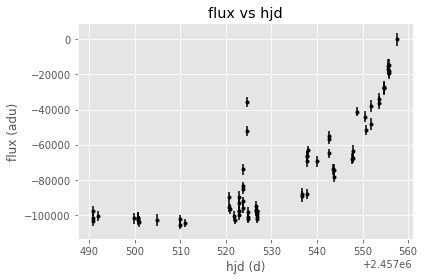

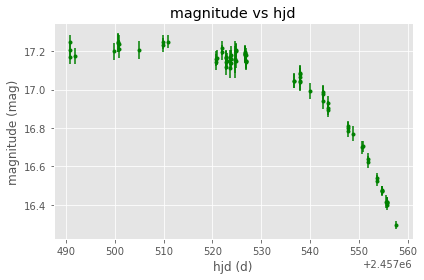

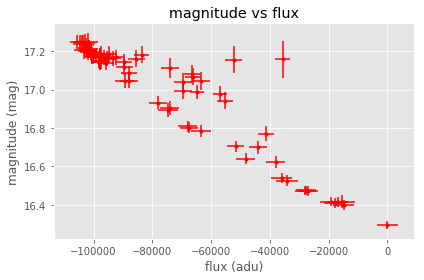

In [14]:
points_plot = NdPointPlot(ts, dataset)
points_plot.plot_xy_by_name('hjd', 'flux')
points_plot.plot_xy_by_name('hjd', 'magnitude', fmt='g.')
points_plot.plot_xy_by_name('flux', 'magnitude', fmt='r.')

<a id="invariance"></a>
Invariance of VODML serializations
=====================

We introduced an example with a simple sky position in our first example. Then we parsed a much more complicated serialization of a time series, which also includes positional information.

It is worth stressing that despite the fact that the sky position is deep inside an instance of a different data model, the simplistic client we built above still works, i.e.:

In [15]:
new_pos = ts_parser.find_instances(StdPosition)[0]
new_astro_pos = VoSkyCoord(new_pos)
print(new_astro_pos)

<SkyCoord (FK4: equinox=J2000.000, obstime=J2000.000): (ra, dec) in deg
    ( 269.82846, -27.99478)>


<a id="tests"></a>
Tests
===

In [16]:
assert_approx_equal(10.684591543245, astropos_fk5_j2000.fk5.ra.deg, significant=10)
assert_approx_equal(41.269171456186264, astropos_fk5_j2000.fk5.dec.deg, significant=10)

assert_approx_equal(10.68458000395546, astropos_icrs.ra.deg, significant=10)
assert_approx_equal(41.269169997096114, astropos_icrs.dec.deg, significant=10)

assert_approx_equal(121.17424181434197, astropos_galactic.l.deg, significant=10)
assert_approx_equal(-21.57288557543883, astropos_galactic.b.deg, significant=10)

In [17]:
assert 1 == len(sky_positions)
assert 10.34209135 == pos.coord.ra.value
assert 41.13232112 == pos.coord.dec.value
assert "FK5" == pos.coord.frame.space_ref_frame.value
assert "J1975" == pos.coord.frame.equinox.value
assert "TOPOCENTER" == pos.coord.frame.ref_position.position.value

In [18]:
assert 1 == len(points)
assert "TIMESERIES" == dataset.data_product_type.value
assert "K2C9 VST MOA-2016-BLG-0254_VST_r_SDSS78.t" == dataset.data_id[0].title.value
assert "ivo://org.gavo.dc/~?k2c9vst/data/?MOA-2016-BLG-0254_VST_r_SDS..." == dataset.curation[0].publisher_did.value
assert "http://archive.eso.org/wdb/wdb/eso/sched_rep_arc/query?progid..." == dataset.curation[0].reference[0].ref_code.value

In [19]:
time = ts.observable[0].measure[0]
position = ts.observable[1].measure[0]
flux = ts.observable[2].measure[0]
magnitude = ts.observable[3].measure[0]

assert isinstance(time, StdTimeMeasure)
assert isinstance(position, StdPosition)
assert isinstance(flux, GenericCoordMeasure)
assert isinstance(magnitude, GenericCoordMeasure)

assert 75 == len(time.coord.date)
assert 2457557.6532016 == time.coord.date.value[0]
assert "TT" == time.coord.frame.timescale.value
assert "HELIOCENTER" == time.coord.frame.ref_position.position.value
assert 269.82846 == position.coord.ra.value
assert -27.99478 == position.coord.dec.value
assert 'deg' == position.coord.ra.unit
assert 'deg' == position.coord.dec.unit
assert -14776.0666 == flux.coord.cval[1].value
assert 261.0369873046875 == flux.error[0].stat_error.radius[-1].value
assert 16.40898 == magnitude.coord.cval[2].value
assert 0.002509509911760688 == magnitude.error[0].stat_error.radius[3].value

assert 'mag' == magnitude.coord.cval.unit
assert 'adu' == flux.coord.cval.unit

<a id="beta_lyr"></a>
Beta Lyr time series from Vizier
======================

In [20]:
betalyr_xml = "betalyr-vizier.vot.xml"
betalyr_parser = VodmlParser(betalyr_xml)

betalyr_dataset = betalyr_parser.find_instances(ObsDataset)[0]
betalyr_points = betalyr_parser.find_instances(NdPoint)
betalyr = betalyr_points[0]

In [21]:
betalyr_plot = NdPointPlot(betalyr, betalyr_dataset)

In [22]:
betalyr_plot.dependent

['h_mag', 'j_mag', 'k_mag', 'l_mag', 'm_mag']

In [23]:
betalyr_plot.independent

['position', 'h_time', 'j_time', 'k_time', 'l_time', 'm_time']

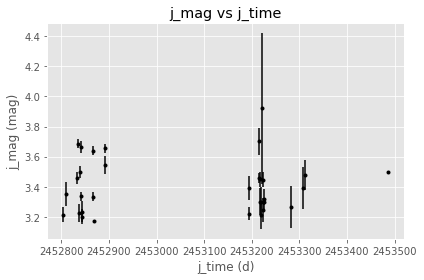

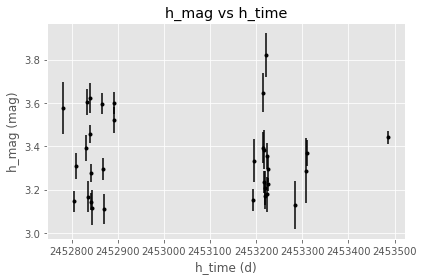

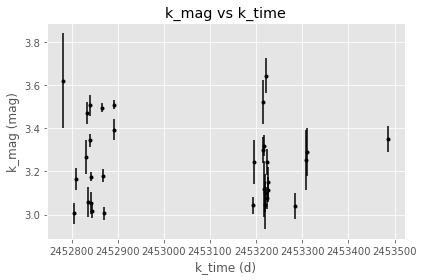

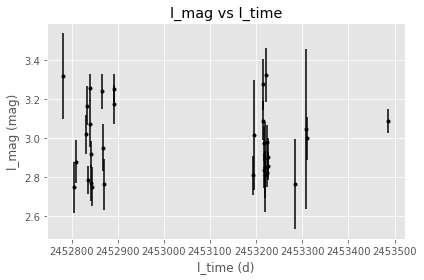

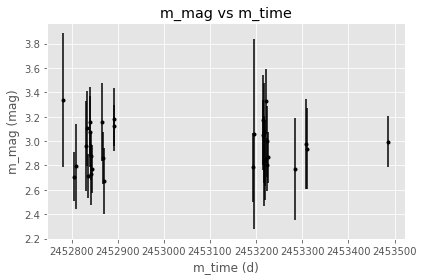

In [24]:
betalyr_plot.plot_xy_by_name('j_time', 'j_mag')
betalyr_plot.plot_xy_by_name('h_time', 'h_mag')
betalyr_plot.plot_xy_by_name('k_time', 'k_mag')
betalyr_plot.plot_xy_by_name('l_time', 'l_mag')
betalyr_plot.plot_xy_by_name('m_time', 'm_mag')